## Importing the relevant libraries

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=3e190e909b2209bed78ae6b681716931ce921a5559692a4aae2b72495fa2a40f
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
!pip install tensorflow==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 38.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, wget, gc
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from wordcloud import WordCloud
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from helper_prabowo_ml import clean_html, remove_, remove_digits, remove_digits, remove_special_characters, removeStopWords, remove_links, punct, email_address, lower, non_ascii

2024-05-04 14:17:18.644768: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading the dataset

In [4]:
df = pd.read_csv("/kaggle/input/symptom2disease/Symptom2Disease.csv")
df.drop('Unnamed: 0',axis=1,inplace=True)
df = df.sample(frac=0.5).reset_index(drop=True)
df.head()

,label,text
0,Pneumonia,I'm having a lot of problems breathing. I'm no...
1,peptic ulcer disease,I have difficulty swallowing food and often ge...
2,Typhoid,"I have had some constipation and belly pain, w..."
3,Common Cold,"I keep sneezing, and I'm miserable and exhaust..."
4,Dengue,I have been experiencing severe joint pain tha...


In [5]:
df.shape

(600, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   600 non-null    object
 1   text    600 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [7]:
df.describe()

,label,text
count,600,600
unique,24,589
top,gastroesophageal reflux disease,I've been constipated and it's really hard to ...
freq,31,3


In [8]:
df.isna().sum()

label    0
text     0
dtype: int64

In [9]:
df.duplicated().sum()

11

In [10]:
df = df.drop_duplicates()
df.shape

(589, 2)

## Exploratory Data Analysis (EDA)

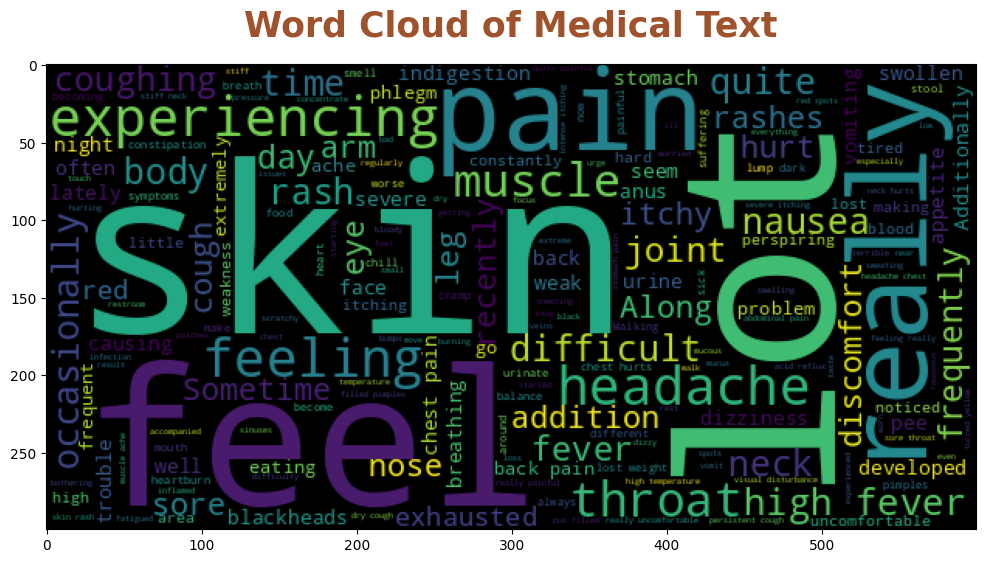

In [11]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df.text))
plt.imshow(wc)
plt.title('Word Cloud of Medical Text',pad=20,fontsize=25,fontweight='bold',color='sienna');

In [12]:
df['num_words'] = df.text.apply(len)
df.num_words.describe()

count    589.000000
mean     170.509338
std       34.631078
min       60.000000
25%      148.000000
50%      169.000000
75%      192.000000
max      295.000000
Name: num_words, dtype: float64

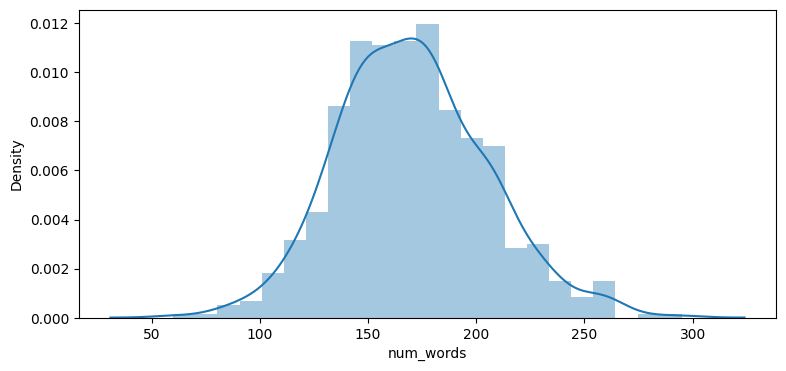

152

In [13]:
plt.figure(figsize=(9,4))
fig = sns.distplot(df['num_words'])
plt.show(fig)
plt.close('all')
del fig
gc.collect()

In [14]:
max_len = 170

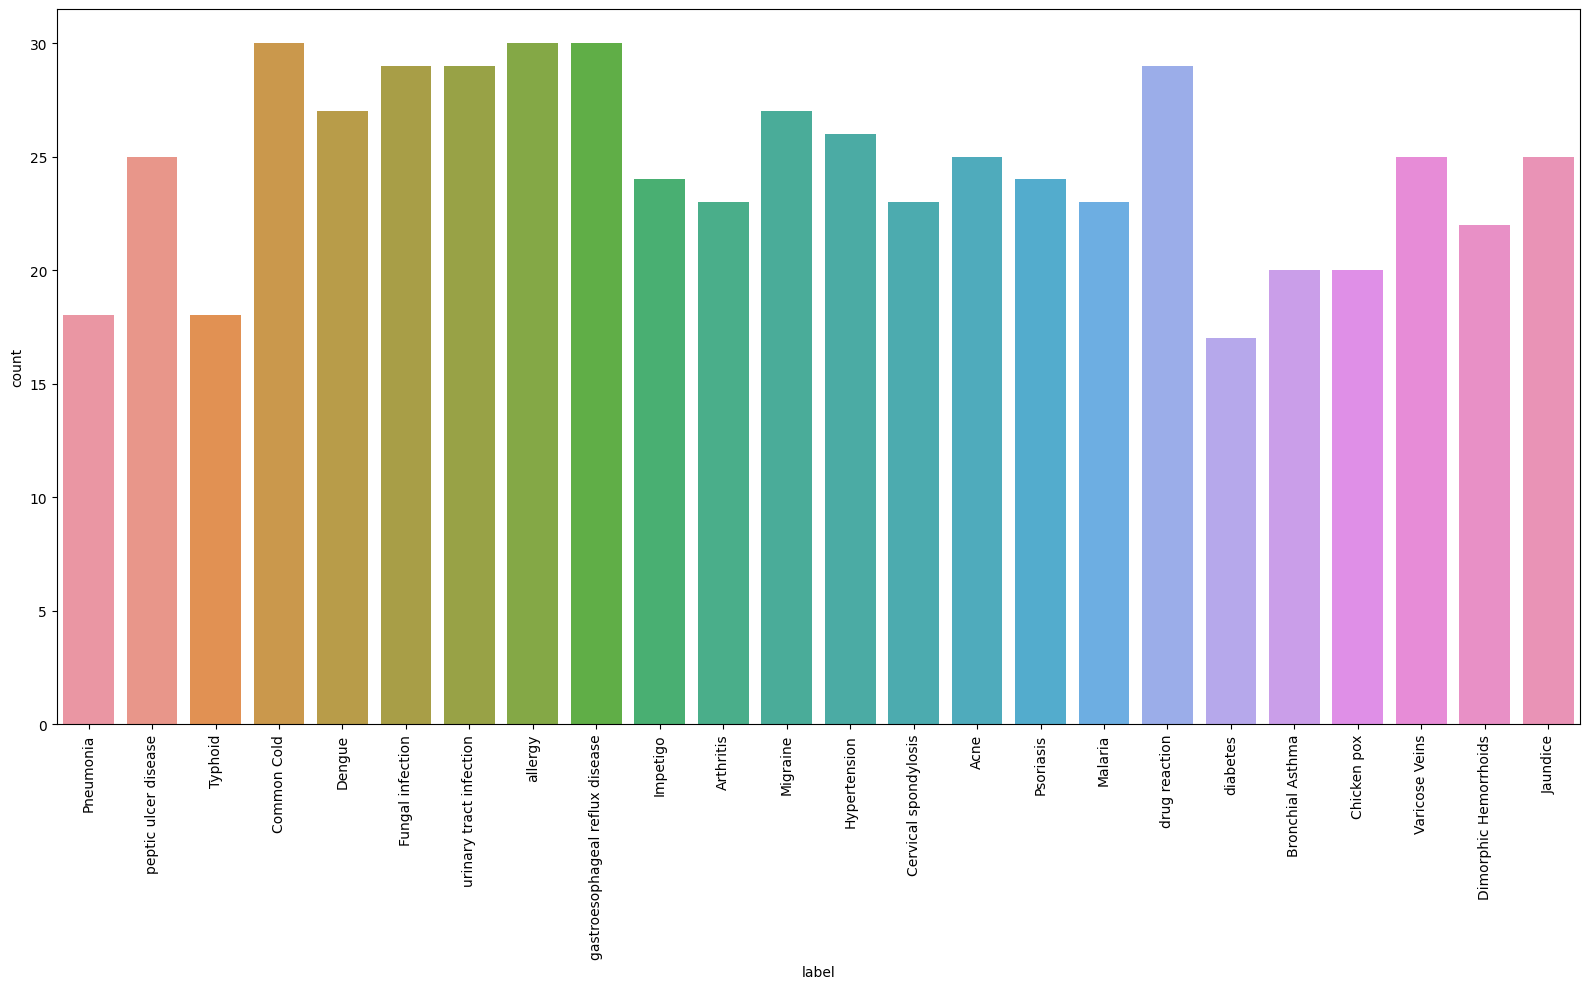

In [15]:
plt.figure(figsize=(16,10))
fig = sns.countplot(x='label',data=df)
plt.xticks(rotation=90,)
plt.tight_layout()
plt.show(fig)
plt.close('all')
del fig
gc.collect();

The target label classes i.e. the case outcomes are relatively imbalanced so this imbalance in the target labels needs to be accounted during model creation.

## Text Preprocessing

In [16]:
def clean_text(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=lower)
    return data

In [17]:
preprocessed_df = clean_text(df,'text')
preprocessed_df.head()

,label,text,num_words
0,Pneumonia,i m lot problems breathing i m feeling good i ...,215
1,peptic ulcer disease,difficulty swallowing food often get sensation...,182
2,Typhoid,constipation belly pain really uncomfortable t...,154
3,Common Cold,keep sneezing i m miserable exhausted lot gunk...,172
4,Dengue,experiencing severe joint pain making day diff...,144


## Encoding the target label classes

In [18]:
encoder = LabelEncoder()
preprocessed_df['label'] = encoder.fit_transform(preprocessed_df['label'])

In [19]:
labels_dict = dict()

for idx, label in enumerate(encoder.classes_):
    labels_dict[idx] = label

labels_dict

{0: 'Acne',
 1: 'Arthritis',
 2: 'Bronchial Asthma',
 3: 'Cervical spondylosis',
 4: 'Chicken pox',
 5: 'Common Cold',
 6: 'Dengue',
 7: 'Dimorphic Hemorrhoids',
 8: 'Fungal infection',
 9: 'Hypertension',
 10: 'Impetigo',
 11: 'Jaundice',
 12: 'Malaria',
 13: 'Migraine',
 14: 'Pneumonia',
 15: 'Psoriasis',
 16: 'Typhoid',
 17: 'Varicose Veins',
 18: 'allergy',
 19: 'diabetes',
 20: 'drug reaction',
 21: 'gastroesophageal reflux disease',
 22: 'peptic ulcer disease',
 23: 'urinary tract infection'}

## Splitting the preprocessed dataset into train and test sets

In [20]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,stratify=preprocessed_df.label,shuffle=True,random_state=101)

## Downloading the Tokenizer and the pretrained BERT transformer model

In [21]:
tokenizer = AutoTokenizer.from_pretrained('ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1')
bert_model = TFAutoModelForSequenceClassification.from_pretrained('ajtamayoh/Symptoms_to_Diagnosis_SonatafyAI_BERT_v1')

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

All the weights of TFBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


## Text Tokenization

In [22]:
X_train = tokenizer(text=train_df.text.tolist(),
                   max_length=max_len,
                   padding='max_length',
                   truncation=True,
                   add_special_tokens=True,
                   return_attention_mask=True,
                   return_tensors='tf',
                   return_token_type_ids=False,
                   verbose=1)

X_test = tokenizer(text=test_df.text.tolist(),
                  max_length=max_len,
                  padding='max_length',
                  truncation=True,
                  add_special_tokens=True,
                  return_attention_mask=True,
                  return_tensors='tf',
                  return_token_type_ids=False,
                  verbose=1)

## Encoding the target labels

In [23]:
y_train = to_categorical(train_df.label)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
y_test = to_categorical(test_df.label)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

## Defining the model architecture

In [25]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [26]:
embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=128,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.2)(output)
output = Dense(units=64,activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.1)(output)
output = Dense(units=32,activation='relu')(output)
output = Dense(units=24,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 170)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 170)]        0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109499158  ['input_ids[0][0]',              
 ation (TFBertForSequenceClassi  rOutput(loss=None,               'attention_mask[0][0]']         
 fication)                      logits=(None, 22),                                                
                                 hidden_states=None                                           

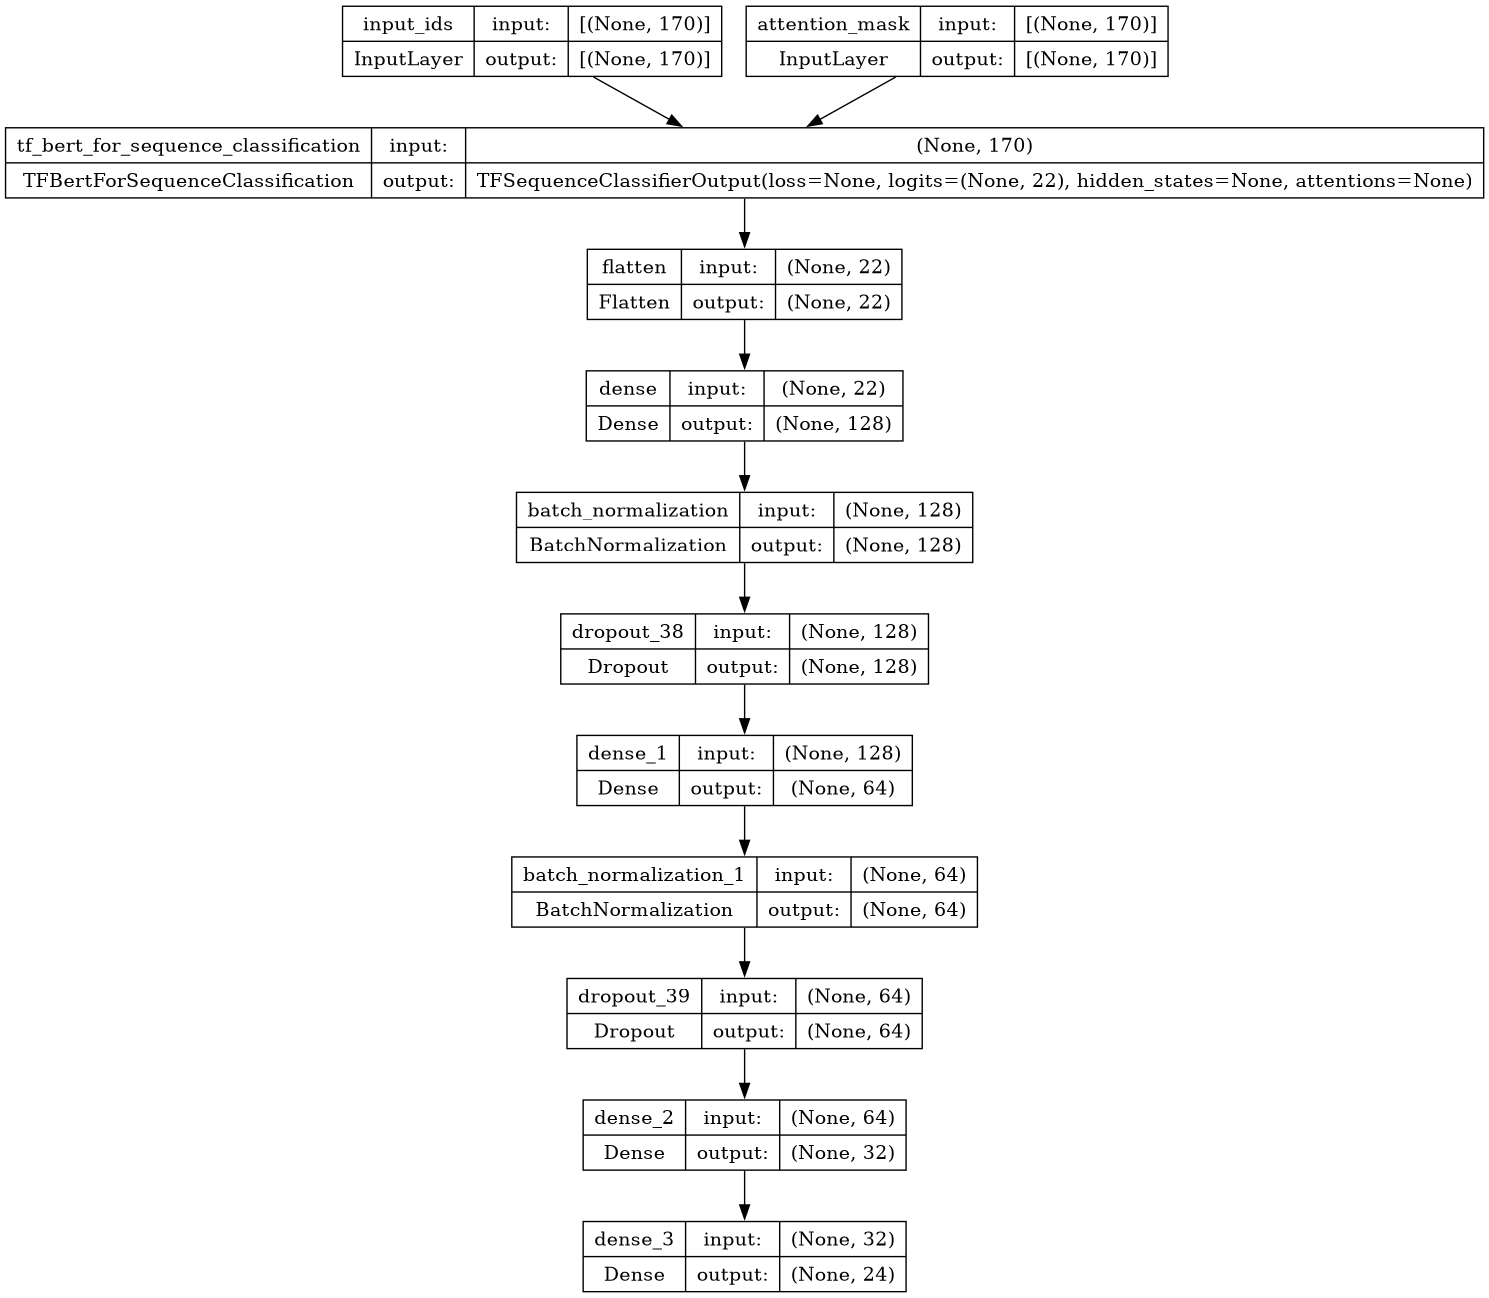

In [27]:
plot_model(model,to_file='model.png',show_shapes=True,dpi=100)

## Compiling the model

In [28]:
adam = Adam(learning_rate=5e-5,epsilon=2e-7,decay=1e-2,clipnorm=1.0)

model.compile(loss=CategoricalCrossentropy(from_logits=True),optimizer=adam,metrics=CategoricalAccuracy('balanced_accuracy'))

## Training the fine-tuned BERT transformer model

In [29]:
def time_based_decay(epoch, lr):
    decay_rate = 1e-5
    decay_epoch = 10
    return lr * (1 / (1 + decay_rate * epoch / decay_epoch))

es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max')
mc = ModelCheckpoint(filepath='symptoms_disease_classifier.keras',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)
lr = LearningRateScheduler(schedule=time_based_decay,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=y_train,
              epochs=100,
              batch_size=32,
              callbacks=[es,mc,lr],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},y_test)
             )


Epoch 1: LearningRateScheduler setting learning rate to 4.999999873689376e-05.
Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 3.3248 - balanced_accuracy: 0.0631 
Epoch 1: val_balanced_accuracy improved from -inf to 0.05085, saving model to symptoms_disease_classifier.keras
13/13 [==============================] - 311s 22s/step - loss: 3.3248 - balanced_accuracy: 0.0631 - val_loss: 3.1608 - val_balanced_accuracy: 0.0508 - lr: 5.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 4.9999948736945024e-05.
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 2.9687 - balanced_accuracy: 0.1189 
Epoch 2: val_balanced_accuracy improved from 0.05085 to 0.10169, saving model to symptoms_disease_classifier.keras
13/13 [==============================] - 279s 22s/step - loss: 2.9687 - balanced_accuracy: 0.1189 - val_loss: 3.0643 - val_balanced_accuracy: 0.1017 - lr: 5.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 4.99998478054

## Evaluating model performance on the test set

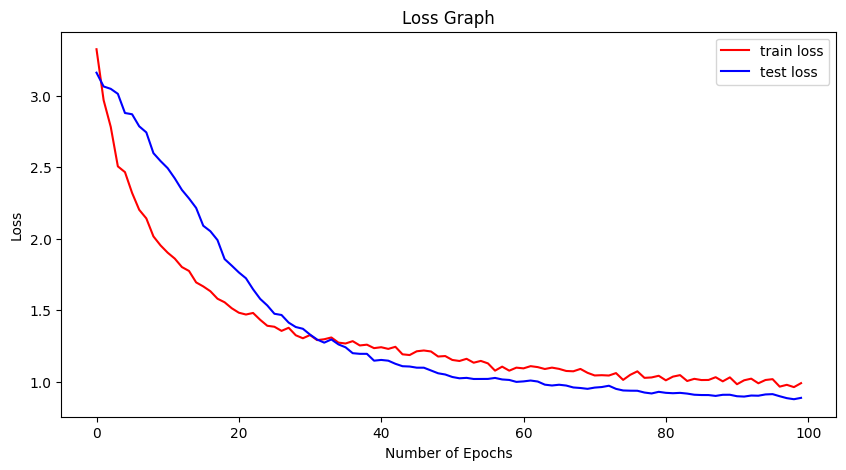

In [30]:
plt.figure(figsize=(10,5))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

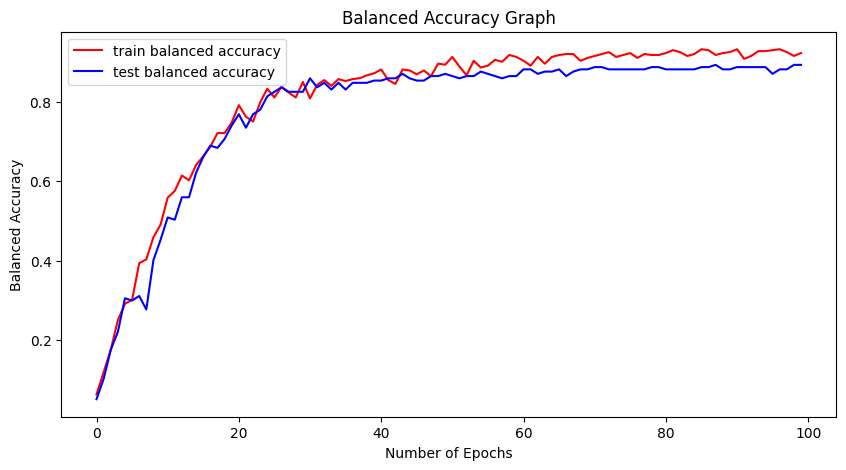

In [31]:
plt.figure(figsize=(10,5))
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Balanced Accuracy')
plt.title('Balanced Accuracy Graph')
plt.legend();

In [32]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
print("Categorical Crossentropy Loss:", loss)
print(f"Balanced Categorical Accuracy: {round(acc*100,2)}%")

6/6 [==============================] - 29s 5s/step - loss: 0.8869 - balanced_accuracy: 0.8927
Categorical Crossentropy Loss: 0.8869413137435913
Balanced Categorical Accuracy: 89.27%


## Loading the model

In [33]:
# custom_objects = {'TFBertForSequenceClassification': TFBertForSequenceClassification}
# lm = load_model('symptoms_disease_classifier.keras',custom_objects=custom_objects)
# lm

## Making predictions on the test set

6/6 [==============================] - 33s 5s/step
Confusion Matrix:
[[7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 3 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 0 0 0 0 0 0]
 [0 0 0 0 0 0

<Figure size 1200x800 with 0 Axes>

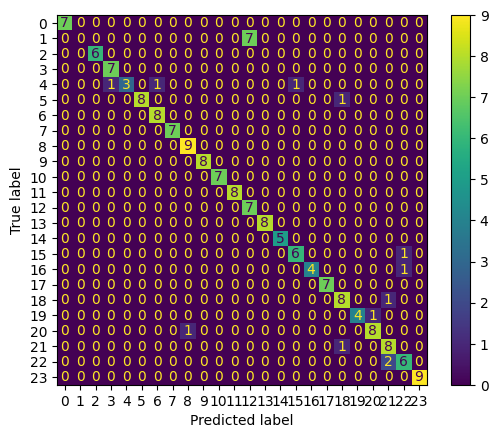

In [34]:
test_pred = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_pred = np.argmax(test_pred,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.label,test_pred))
print('----------------------'*5)
print("Classification Report:")
print(classification_report(test_df.label,test_pred))
print('----------------------'*5)
print("Confusion Matrix Plot:")
plt.figure(figsize=(12,8))
ConfusionMatrixDisplay.from_predictions(test_df.label,test_pred)
plt.show()

## Model Inference

In [35]:
input_text = "I've been experiencing stiffness in my neck and my joints have swollen. I've also been experiencing pain when I walk."

def preprocess_text(text, max_length):
    # Tokenize the input text
    inputs = tokenizer(text, 
                       max_length=max_length,
                       padding='max_length', 
                       truncation=True,  
                       return_tensors="tf",
                       return_attention_mask=True,
                       return_token_type_ids=False,
                       add_special_tokens=True,
                       verbose=1)
    return inputs

inputs = preprocess_text(input_text,max_len)
predictions = model.predict([inputs['input_ids'], inputs['attention_mask']])
predictions = np.argmax(predictions,axis=1)[0]
print("Predicted Label:",labels_dict[predictions])

1/1 [==============================] - 4s 4s/step
Predicted Label: Varicose Veins
